In [16]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df=pd.read_csv("./creditcard.csv")
y_true=df['Class']
df_data=df.drop('Class',1)

In [3]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


## Scaling

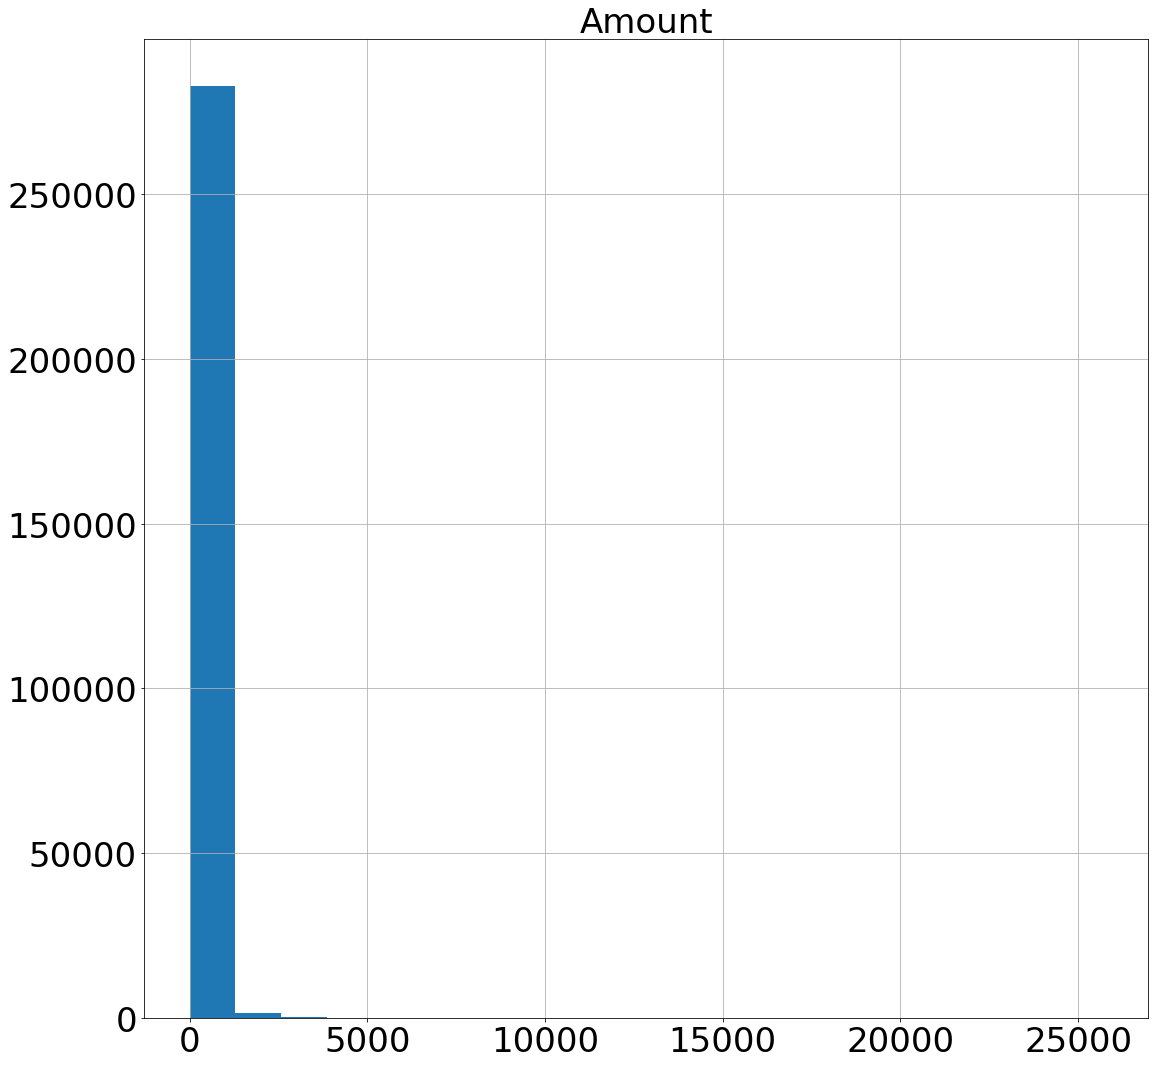

In [17]:
import matplotlib

df['Amount'].hist(bins=20,figsize=(18,18))
plt.title('Amount', fontsize=34)
matplotlib.rc('xtick', labelsize=34) 
matplotlib.rc('ytick', labelsize=34) 
plt.show()

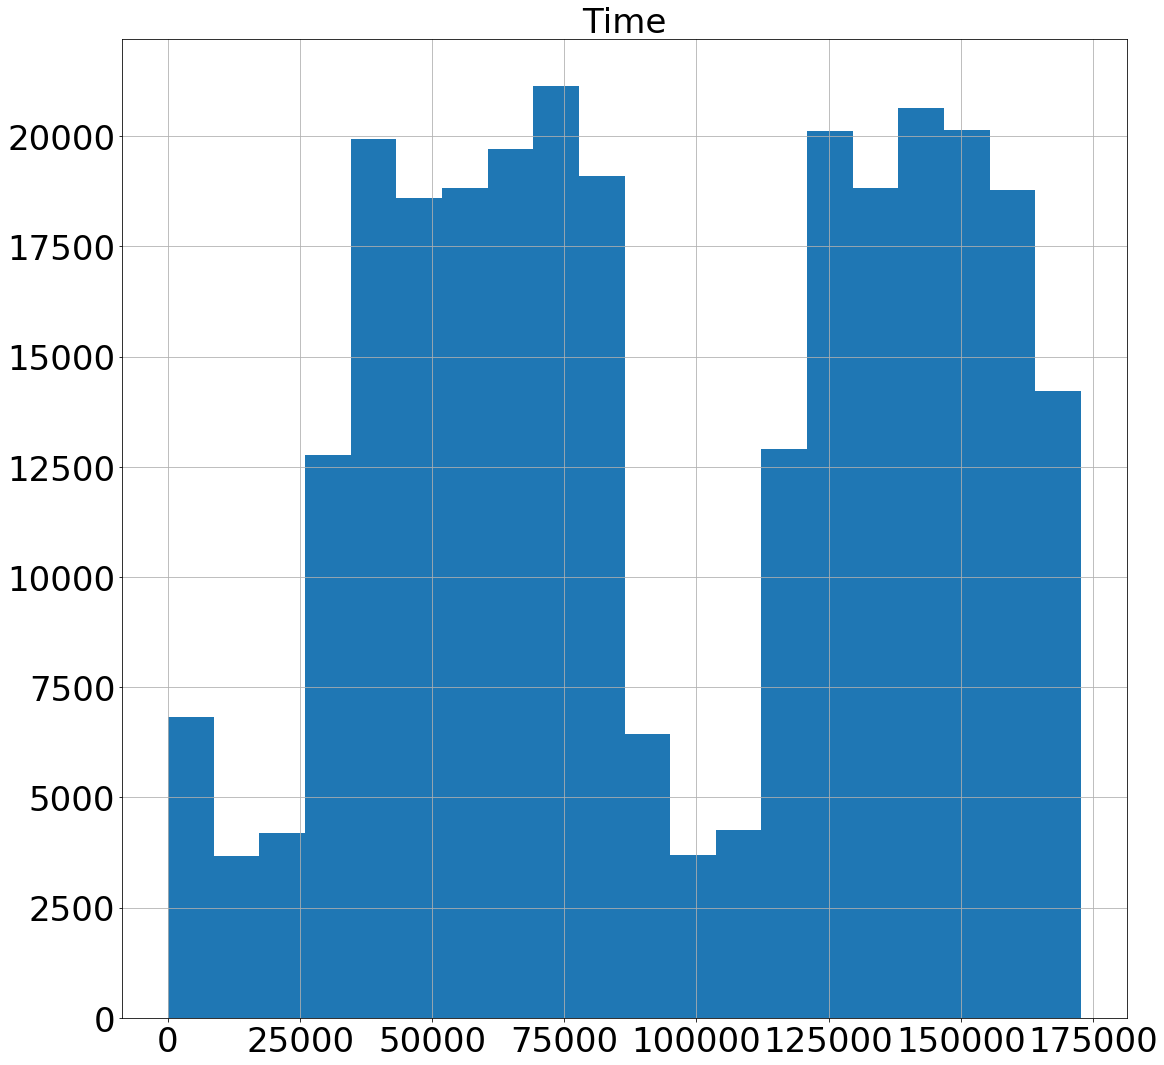

In [18]:
df['Time'].hist(bins=20,figsize=(18,18))
plt.title('Time', fontsize=34)
matplotlib.rc('xtick', labelsize=34) 
matplotlib.rc('ytick', labelsize=34) 
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [20]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Data sampling with SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

y_true=df['Class']
df_data=df.drop('Class',1)

smote = SMOTE(random_state=2)
# smote.fit_sample(df_data, y_true)
X__smote_resampled, y_smote_resampled = smote.fit_sample(df_data, y_true)

new = pd.concat([X__smote_resampled, y_smote_resampled],axis=1)

In [22]:
new.shape

(568630, 31)

## Observe the correlation

In [23]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new2 = normal_distributed_df.sample(frac=1, random_state=42)

new2.shape

(984, 31)

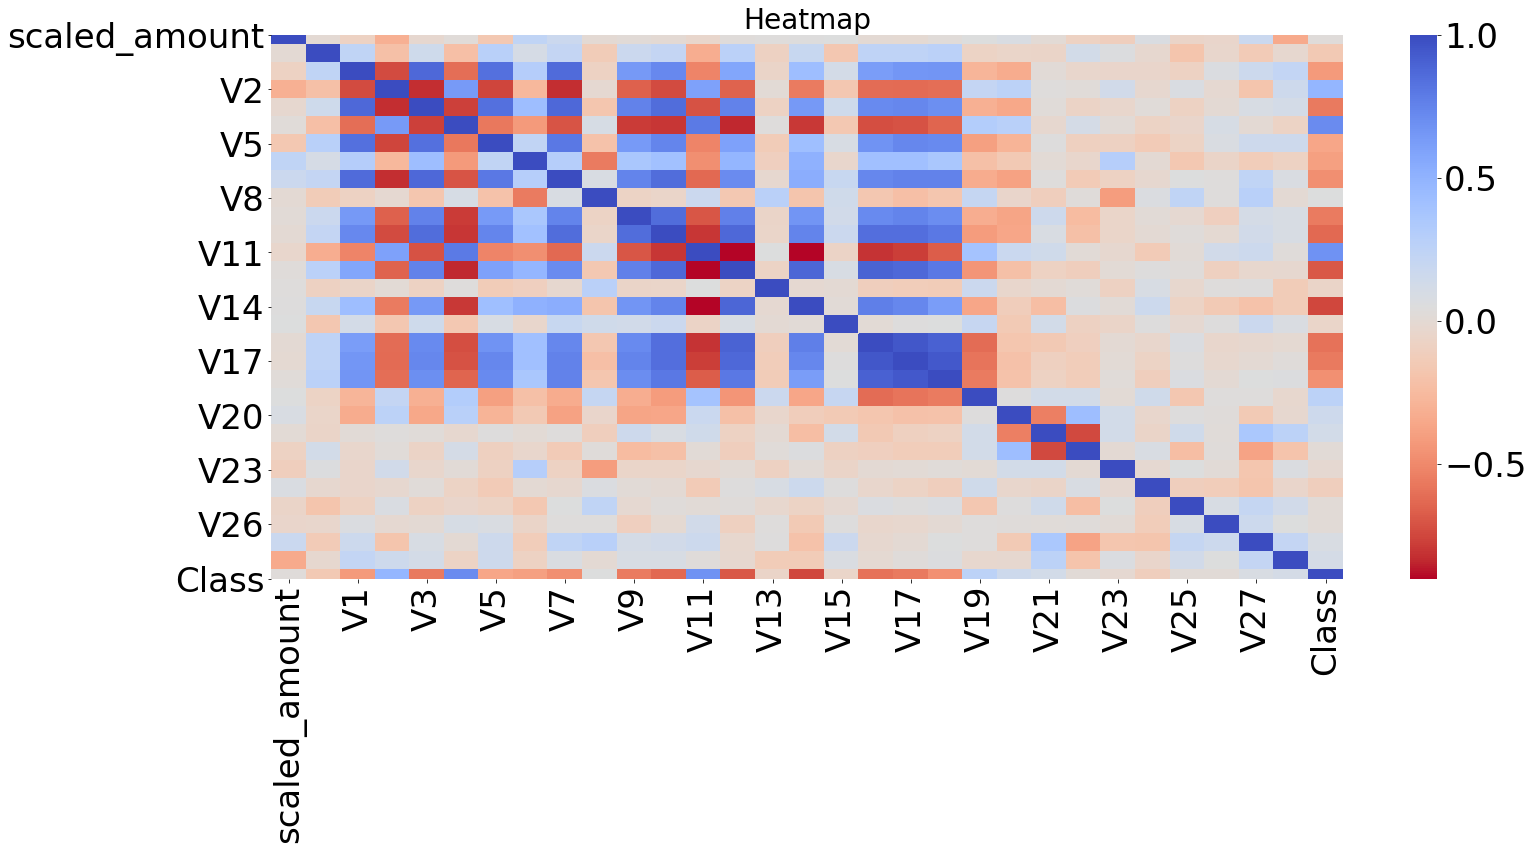

In [24]:
f, ax = plt.subplots(figsize=(24,10))

sub_sample_corr = new2.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':24})
ax.set_title('Heatmap', fontsize=28)
plt.show()

## Remove Outliers

In [25]:
def outlier_removal(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn, [25,75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return lower, upper

In [26]:
V2 = new['V2'].values
V2_lower, V2_upper = outlier_removal(new['V2'])
print('V2 lower and upper are', V2_lower, V2_upper)

outliers = [x for x in V2 if x < V2_lower or x > V2_upper]

print('Feature V2 Outliers: {}'.format(len(outliers)))

new = new.drop(new[(new['V2'] > V2_upper) | (new['V2'] < V2_lower)].index)

V2 lower and upper are -4.528117466657535 7.196760586190516
Feature V2 Outliers for Fraud Cases: 49308


In [27]:
V10 = new['V10'].values
V10_lower, V10_upper = outlier_removal(new['V10'])
print('V10 lower and upper are', V10_lower, V10_upper)

outliers = [x for x in V10 if x < V10_lower or x > V10_upper]

print('Feature V10 Outliers: {}'.format(len(outliers)))

new = new.drop(new[(new['V10'] > V10_upper) | (new['V10'] < V10_lower)].index)

V10 lower and upper are -9.35929518770394 5.70048031063105
Feature V10 Outliers for Fraud Cases: 24979


In [28]:
V14 = new['V14'].values
V14_lower, V14_upper = outlier_removal(new['V14'])
print('V14 lower and upper are', V14_lower, V14_upper)

outliers = [x for x in V14 if x < V14_lower or x > V14_upper]

print('Feature V14 Outliers: {}'.format(len(outliers)))

new = new.drop(new[(new['V14'] > V14_upper) | (new['V14'] < V14_lower)].index)

V14 lower and upper are -13.089291732943668 8.159222526570616
Feature V14 Outliers for Fraud Cases: 2983


## PCA with Smote

In [29]:
X = new.drop('Class', axis=1)
y = new['Class']

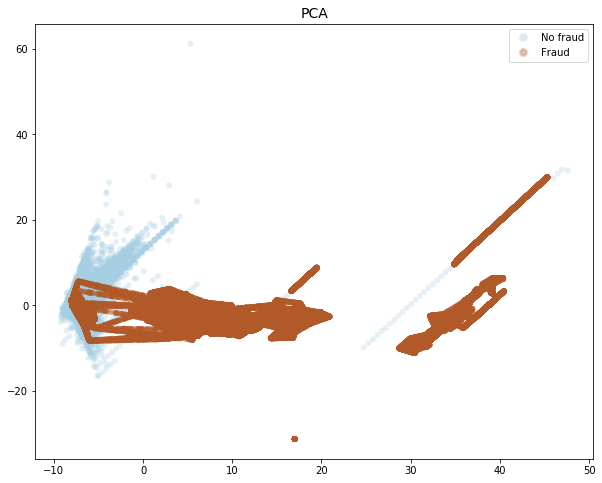

In [10]:
## PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
p = pca.fit_transform(X)
plt.figure(figsize=(10,8))
l = ['No fraud','Fraud']
graph = plt.scatter(p[:,0], p[:,1], c=y, cmap = "Paired", linewidths=3,alpha=0.3, edgecolors='none') 
plt.legend(handles=graph.legend_elements()[0],labels = l)
plt.title('PCA', fontsize=14)

plt.show()

## T-SNE 

In [ ]:
# T-SNE
from sklearn.manifold import TSNE

q = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(10,8))
plt.scatter(q[:,0], q[:,1], c = y, cmap = "Paired", alpha=0.8)
l = ['No fraud','Fraud']
graph = plt.scatter(p[:,0], p[:,1], c=y, cmap = "Paired", linewidths=2,alpha=0.8, edgecolors='none') 
plt.legend(handles=graph.legend_elements()[0],labels = l)
plt.title('T-SNE', fontsize=14)

plt.show()

## Training and Testing without outliers

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,f1_score


In [32]:
# LogisticRegression
classif = LogisticRegression()
time_start = time.process_time()
model=classif.fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start


y_pred = model.predict(X_test)
train_score = classif.score(X_train, y_train)
test_score = classif.score(X_test, y_test)
roc=roc_auc_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Roc score is',roc, 'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.9360952806693209 recall score is 0.8982309256894186 f1 score is 0.9295023189221601 precision score 0.9630296422141643 time 11.645779708000003


In [33]:
#RandomForestClassifier

classif = RandomForestClassifier()
time_start = time.process_time()
model_rf =classif.fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_pred_rf = model_rf.predict(X_test)
roc=roc_auc_score(y_test,y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.999910698338989 recall score is 1.0 f1 score is 0.9998817603518811 precision score 0.9997635486616854 time 258.068699381


In [34]:
# Knn
time_start = time.process_time()
model_knn = KNeighborsClassifier().fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_knn_pred = model_knn.predict(X_test)
roc=roc_auc_score(y_test,y_knn_pred)
recall = recall_score(y_test, y_knn_pred)
f1 = f1_score(y_test, y_knn_pred)
precision = precision_score(y_test, y_knn_pred)

print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.9988569387390606 recall score is 1.0 f1 score is 0.9984886411939735 precision score 0.9969818439047394 time 2.555944507999982


In [35]:
# MLP
model_mlp = MLPClassifier(alpha=1)
time_start = time.process_time()
model = model_mlp.fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start


y_mlp_pred = model.predict(X_test)
precision = precision_score(y_test, y_mlp_pred)
roc=roc_auc_score(y_test,y_mlp_pred)
recall = recall_score(y_test, y_mlp_pred)
f1 = f1_score(y_test, y_mlp_pred)
print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.9703512626619564 recall score is 0.9544014001229838 f1 score is 0.9676870136565832 precision score 0.9813477298703825 time 222.637782624


In [36]:
# GradientBoostingClassifier
time_start = time.process_time()
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_gb_pred = model_gb.predict(X_test)

roc=roc_auc_score(y_test,y_gb_pred)
recall = recall_score(y_test, y_gb_pred)
f1 = f1_score(y_test, y_gb_pred)
precision = precision_score(y_test, y_gb_pred)
print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.9741037762432981 recall score is 0.9616385223026347 f1 score is 0.9716347647382131 precision score 0.9818410122669757 time 552.2401291850001


In [37]:
# GaussianNB
time_start = time.process_time()
model_g = GaussianNB().fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start


y_g_pred = model_g.predict(X_test)
roc=roc_auc_score(y_test,y_g_pred)
recall = recall_score(y_test, y_g_pred)
f1 = f1_score(y_test, y_g_pred)
precision = precision_score(y_test, y_g_pred)


print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.8906757001880036 recall score is 0.8138214843195686 f1 score is 0.876576232327092 precision score 0.9498178204703545 time 0.2491846699999769


In [38]:
#decision
time_start = time.process_time()
model_des = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_des_pred = model_des.predict(X_test)

roc=roc_auc_score(y_test,y_des_pred)
recall = recall_score(y_test, y_des_pred)
f1 = f1_score(y_test, y_des_pred)
precision = precision_score(y_test, y_des_pred)

print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

Roc score is 0.9980134644652254 recall score is 0.9985809564353626 f1 score is 0.9976018051437145 precision score 0.9966245721704237 time 33.291831556000034


## Training and Testing with outliers

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X__smote_resampled, y_smote_resampled, test_size=0.2, random_state=42)

In [ ]:
# LogisticRegression
classif = LogisticRegression()
time_start = time.process_time()
model=classif.fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start


y_pred = model.predict(X_test)
train_score = classif.score(X_train, y_train)
test_score = classif.score(X_test, y_test)
roc=roc_auc_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('Roc score is',roc, 'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

In [ ]:
#RandomForestClassifier

classif = RandomForestClassifier()
time_start = time.process_time()
model_rf =classif.fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_pred_rf = model_rf.predict(X_test)
roc=roc_auc_score(y_test,y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

In [ ]:
# Knn
time_start = time.process_time()
model_knn = KNeighborsClassifier().fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_knn_pred = model_knn.predict(X_test)
roc=roc_auc_score(y_test,y_knn_pred)
recall = recall_score(y_test, y_knn_pred)
f1 = f1_score(y_test, y_knn_pred)
precision = precision_score(y_test, y_knn_pred)

print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

In [ ]:
# MLP
model_mlp = MLPClassifier(alpha=1)
time_start = time.process_time()
model = model_mlp.fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start


y_mlp_pred = model.predict(X_test)
precision = precision_score(y_test, y_mlp_pred)
roc=roc_auc_score(y_test,y_mlp_pred)
recall = recall_score(y_test, y_mlp_pred)
f1 = f1_score(y_test, y_mlp_pred)
print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

In [ ]:
# GradientBoostingClassifier
time_start = time.process_time()
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_gb_pred = model_gb.predict(X_test)

roc=roc_auc_score(y_test,y_gb_pred)
recall = recall_score(y_test, y_gb_pred)
f1 = f1_score(y_test, y_gb_pred)
precision = precision_score(y_test, y_gb_pred)
print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

In [ ]:
# GaussianNB
time_start = time.process_time()
model_g = GaussianNB().fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start


y_g_pred = model_g.predict(X_test)
roc=roc_auc_score(y_test,y_g_pred)
recall = recall_score(y_test, y_g_pred)
f1 = f1_score(y_test, y_g_pred)
precision = precision_score(y_test, y_g_pred)


print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)

In [ ]:
#decision
time_start = time.process_time()
model_des = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
time_end = time.process_time()
training_time = time_end - time_start

y_des_pred = model_des.predict(X_test)

roc=roc_auc_score(y_test,y_des_pred)
recall = recall_score(y_test, y_des_pred)
f1 = f1_score(y_test, y_des_pred)
precision = precision_score(y_test, y_des_pred)

print('Roc score is',roc,'recall score is', recall,'f1 score is',f1,'precision score',precision,'time',training_time)